# Fleet Computation

The `/trajectory` endpoints in [Contrails API](https://api.contrails.org) were designed to evaluate a scientific model over a single flight. Here, a **flight** is a sequence of discrete temporal spatial points defining the 1-dimensional path of a flight.

A common use-case evaluates a scientific model over a collection flights (hereby dubbed a **fleet**). This can be achieved through this API by simply sequentially calling an endpoint for each flight in the fleet. In most cases, this sequential computation is *not* optimal.

Many computations in the backend can be performed substantially faster if run in tandem rather than sequentially over distinct flights. To this end, Contrails API supports **fleet computation**. A sequence of flights can be concatenated into a single POST request body for ingestion by the API. An additional `flight_id` field is required to decompose the fleet object into individual flights. In general, this mode of computation will be nearly as fast as if calling the API with a single flight trajectory.

This notebook demonstrate best practices for fleet computation in Contrails API.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/contrailcirrus/2023-04-pycontrails-workshop/blob/main/notebooks/04-API-Fleet-mode.ipynb)

In [ ]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install requests

In [1]:
import os
import matplotlib.colors as mcolors
import pandas as pd
import requests

In [2]:
# Define credentials
URL = "https://api.contrails.org/v0"
api_key = "ADD API KEY"
headers = {"x-api-key": api_key}

# Confirm credentials are valid
r = requests.get(f"{URL}/auth/validate-key", headers=headers)
print(f"HTTP Response Code: {r.status_code} {r.reason}")

HTTP Response Code: 200 OK


## Create a fleet

Here, we load a sample fleet of pre-cleaned flight trajectories from 2023-02-10. This sample is [available for download](../_static/fleet_sample.csv) as a CSV file.

In [3]:
df = pd.read_csv("../_static/fleet_sample.csv")
df.head()

,flight_id,engine_uid,aircraft_type,longitude,latitude,altitude,time
0,b5ad83811c43ba5ad584eda8c4b6d836,01P10IA020,A319,-74.178192,40.684994,12.0,2023-02-10T19:48:40Z
1,b5ad83811c43ba5ad584eda8c4b6d836,01P10IA020,A319,-74.177826,40.685491,12.0,2023-02-10T19:49:00Z
2,b5ad83811c43ba5ad584eda8c4b6d836,01P10IA020,A319,-74.177460,40.685989,12.0,2023-02-10T19:49:20Z
3,b5ad83811c43ba5ad584eda8c4b6d836,01P10IA020,A319,-74.177424,40.686048,12.0,2023-02-10T19:49:40Z
4,b5ad83811c43ba5ad584eda8c4b6d836,01P10IA020,A319,-74.177387,40.686107,12.0,2023-02-10T19:50:00Z


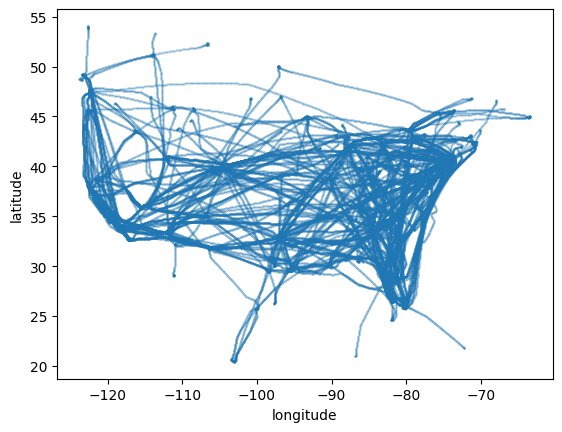

In [4]:
df.plot.scatter("longitude", "latitude", s=0.1, alpha=0.3);

In [5]:
print(f"Number of flights: {df['flight_id'].nunique()}")
print(f"Number of waypoints: {len(df)}")

# Convert to dictionary form expected by the API
request_json = df.to_dict("list")

Number of flights: 500
Number of waypoints: 184910


## POST the fleet to the `/trajectory/sac` endpoint

In the API, fleet computation is enabled by including a `flight_id` field int the request body. Each `/trajectory` endpoint supports fleet computation. Here we pass our fleet into the [/trajectory/sac](https://api.contrails.org/openapi#/Trajectory/schmidt_appleman_contrail_formation_criteria_v0_trajectory_sac_post) endpoint.

Even though our fleet contains several hundred flights, the API computes the SAC in nearly the same time it would take for it to compute SAC over an individual flight.

In [6]:
# Expect the request to take ~1 minute
r = requests.post(f"{URL}/trajectory/sac", json=request_json, headers=headers)
print(f"HTTP Response Code: {r.status_code} {r.reason}")
r_json = r.json()

HTTP Response Code: 200 OK


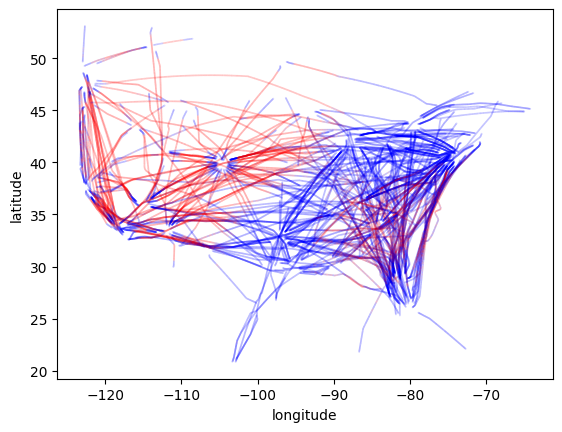

In [7]:
# Plot the response
tmp = df.assign(sac=r_json["sac"])

cmap = mcolors.ListedColormap(["blue", "red"])
tmp.plot.scatter(x="longitude", y="latitude", c="sac", cmap=cmap, s=0.1, alpha=0.1, colorbar=False);

## POST fleet to the `/trajectory/cocip` endpoint

The CoCiP model is more computationally intense than the SAC. Still, fleet computation is substantially faster than running each flight through the API sequentially. We pass our fleet into the [/trajectory/cocip](https://api.contrails.org/openapi#/Trajectory/contrail_cirrus_predictions_v0_trajectory_cocip_post) endpoint.

In [8]:
# Expect the request to take 2 - 3 minutes
r = requests.post(f"{URL}/trajectory/cocip", json=request_json, headers=headers)
print(f"HTTP Response Code: {r.status_code} {r.reason}")
r_json = r.json()

HTTP Response Code: 200 OK


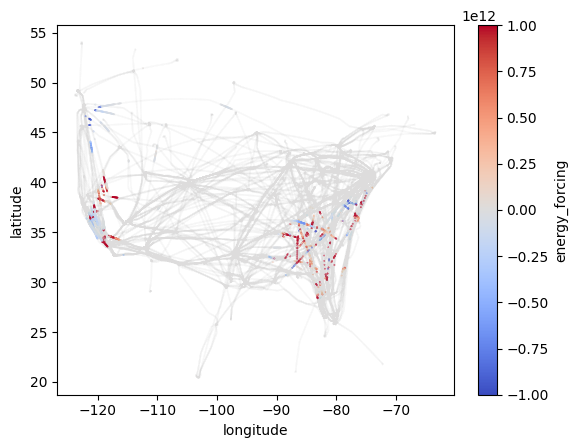

In [9]:
# Plot energy forcing
tmp = df.assign(energy_forcing=r_json["energy_forcing"])
tmp.plot.scatter(
    x="longitude",
    y="latitude",
    c="energy_forcing",
    cmap="coolwarm",
    vmin=-1e12,
    vmax=1e12,
    s=0.1,
    alpha=0.02 + 0.9 * (tmp["energy_forcing"].abs() > 1e10).astype(float),
);

## Other considerations

### Constraints

In addition to all of the constraints already in place for "flight computation" (see the `Trajectory` schema in the [api docs](https://api.contrails.org/openapi)), several additional constraints are included for "fleet computation".

- The total duration (difference between extreme times) is at most 24 hours
- The fleet is comprised of at most 1000 flights.
- The fleet has no more than 300,000 waypoints.

> It's possible that the API will return a `500` error if all of its memory is consumed by fleet computation. In this case, the fleet should be broken into smaller chunks and POSTed to the API sequentially.

### Scalar values and aircraft performance

When passing in a single flight into the API, many fields can be defined by scalar or vector quantities. For example, fields such as `aircraft_type`, `engine_uid`, or `wingspan` are constant for a single flight, and so the API expects a single value (as opposed to an array) to be included in the request payload. When using the API for fleet computation, these values may vary over different flights. Consequently, an array of values may be included in the request body (as we've done in this example notebook with `aircraft_type` and `engine_uid`).

### Independence of computational mode

We expect flight and fleet computation to give identical results. Fleet computation simply provides a speedup.